<a href="https://colab.research.google.com/github/alagarde-bit/Computer-Vision/blob/main/lab15_Lagardeipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC 4466 Computer Vision
## Day 18 - Convolutional Neural Networks with Tensorflow
Adapted from:
- Tensorflow image classification tutorial https://www.tensorflow.org/tutorials/images/classification
- Practical Machine Learning for Computer Vision by Lakshmanan


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


## Get the data

In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='15VrN2Bc-7fZd1Z4JH55H_B-o47A5ZhVW',
                                    dest_path= '/content/animals.zip',
                                    unzip=True)

## Visualize an example image

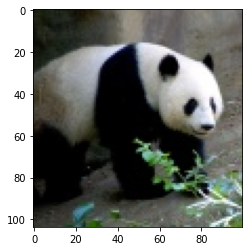

In [3]:
bgr = cv2.imread('animals/panda/panda_00001.jpg')
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)
plt.show()

# Set some parameters
We'll process images in batches of 32 at a time, and we'll resize each image to 180 x 180.

In [4]:
batch_size = 32
img_height = 180
img_width = 180


In [5]:
# This is the folder where our images are
data_dir = 'animals'

# Tensorflow will choose some of the images as training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3000 files belonging to 3 classes.
Using 2400 files for training.


In [6]:
# Tensorflow will chooose the rest of the images as validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3000 files belonging to 3 classes.
Using 600 files for validation.


In [7]:
# The class names (the names of the different types of images) are
# automatically inferred from the folder names.
class_names = train_ds.class_names
print(class_names)


['cats', 'dogs', 'panda']


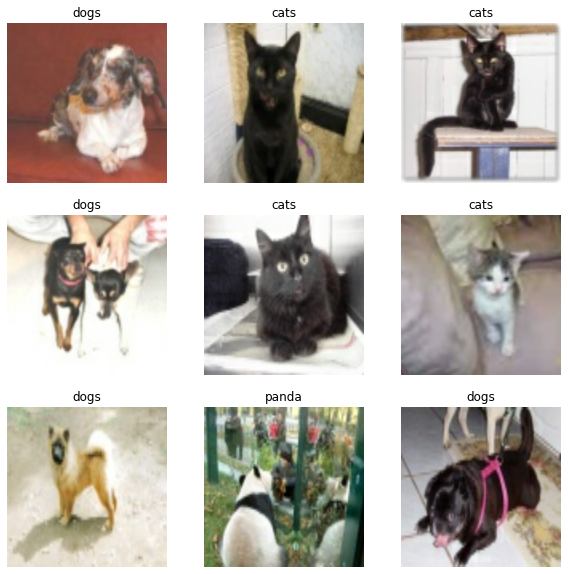

In [8]:
# The Tensorflow train_ds object makes it easy to get to the images and 
# visualize them
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


## Set a few values to make performance better for loading images

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


## Create the neural network (model)

In [30]:
num_classes = len(class_names)

# The model will first normalize the pixel values into the range 0-1.
# Then flatten the images so each is a long vector of numbers.
# Then connect that to a hidden (Dense) layer with 32 neurons.
# Then create 3 outputs, one per class.
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(200, activation='relu'),
  layers.Dense(200, activation='relu'),
  layers.Dense(num_classes)
])


In [31]:
# Compiling the model gets it ready to train.
# We tell it which optimizer to use to find the best weights (Adam),
# What the learning rate is (how big a step to take while optimizing),
# and what loss function to use, and what metrics to keep track of (accuracy).
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [28]:
# Print out a summary of the layers of the model.
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 180, 180, 16)      1216      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 90, 90, 32)        12832     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

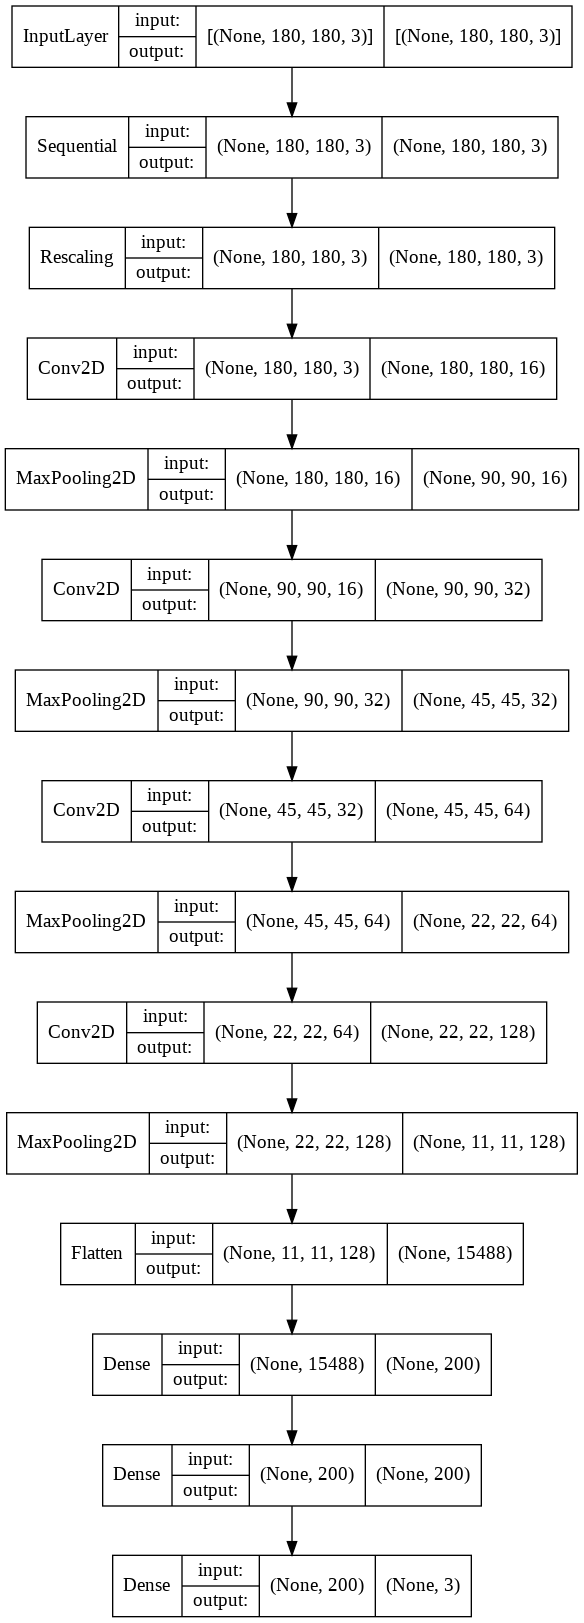

In [32]:
# Visualize the layers of the model.
# (None, 180, 180, 3) means that the model can handle various numbers of images,
# but they all have to be 180x180 and have 3 color channels.
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

## Train (fit) the model
An epoch is one iteration of training, where the model sees each training example one time.

In [33]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/50
75/75 [==============================] - 7s 82ms/step - loss: 1.0908 - accuracy: 0.3792 - val_loss: 1.0763 - val_accuracy: 0.4950
Epoch 2/50
75/75 [==============================] - 6s 80ms/step - loss: 1.0330 - accuracy: 0.5079 - val_loss: 0.9734 - val_accuracy: 0.5433
Epoch 3/50
75/75 [==============================] - 6s 79ms/step - loss: 0.9085 - accuracy: 0.5700 - val_loss: 0.8799 - val_accuracy: 0.5550
Epoch 4/50
75/75 [==============================] - 6s 78ms/step - loss: 0.8352 - accuracy: 0.5900 - val_loss: 0.8103 - val_accuracy: 0.6167
Epoch 5/50
75/75 [==============================] - 6s 79ms/step - loss: 0.8042 - accuracy: 0.5854 - val_loss: 0.7792 - val_accuracy: 0.6133
Epoch 6/50
75/75 [==============================] - 6s 79ms/step - loss: 0.7735 - accuracy: 0.6033 - val_loss: 0.7835 - val_accuracy: 0.6233
Epoch 7/50
75/75 [==============================] - 6s 79ms/step - loss: 0.7527 - accuracy: 0.6217 - val_loss: 0.7645 - val_accuracy: 0.6300
Epoch 8/50
75

## Visualize the results

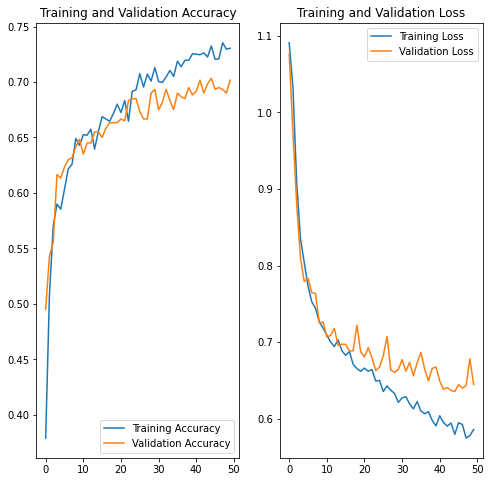

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

5. The vanilla CNN greatly outperforms a vanilla ANN. The vanilla ANN had a training accuracy of 33% and a testing accuracy of 32%. The vanilla CNN on the other hand has a training accuracy of 99% and a testing accuracy of 65%. 

6. After adding the extra layers, the performance did not improve. Testing accuracy stayed the same and training accuracy dropped to 96%

7. After adding neurons, a hidden layer, data augmentation, a learning rate of 0.00001, an activation function of RELU, 50 epochs, a convolutio kernel of 5, and learning more outputs, the best testing accuracy I could get is 70%. 